# Imports

In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Data Preprocessing

In [2]:
# Define data augmentation and preprocessing for training and validation 
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True
)

# Load and preprocess training and validation data 
train_generator = datagen.flow_from_directory(
    'data/train',
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',  # Change class_mode to 'categorical'
    shuffle=True
)
validation_generator = datagen.flow_from_directory(
    'data/valid',
    target_size=(256, 256), 
    batch_size=64,
    class_mode='categorical',  # Change class_mode to 'categorical'
    shuffle=False
)

Found 4730 images belonging to 7 classes.
Found 1102 images belonging to 7 classes.


# Model Building

In [3]:
# Load pre-trained EfficientNetV2B0
base_model = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3),
    pooling='max',
    classes=7,
    include_preprocessing=True
)

# Add custom classification head
x = base_model.output
predictions = Dense(7, activation='softmax')(x)

# Combine base model and custom head
model = Model(inputs=base_model.input, outputs=predictions)

# Make base model layers trainable
for layer in base_model.layers:
    layer.trainable = True

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 256, 256, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 256, 256, 3)       │               0 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 128, 128, 32)      │             864 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 128, 128, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 128, 128, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 128, 128, 16)      │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 128, 128, 16)      │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 128, 128, 16)      │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 64, 64, 64)        │           9,216 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_bn             │ (None, 64, 64, 64)        │             256 │ block2a_expand_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_activation     │ (None, 64, 64, 64)        │               0 │ block2a_expand_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_conv (Conv2D) │ (None, 64, 64, 32)        │           2,048 │ block2a_expand_activation… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_bn            │ (None, 64, 64, 32)        │             128 │ block2a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2b_expand_conv (Conv2D)  │ (None, 64, 64, 128)       │          36,86

 Total params: 5,928,279 (22.61 MB)

 Trainable params: 5,867,671 (22.38 MB)

 Non-trainable params: 60,608 (236.75 KB)

# Model Training

In [4]:
history = model.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator
)

Epoch 1/50


C:\Users\Sakadyk\anaconda3\envs\pi24\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


74/74 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.1451 - loss: 5.4715 - val_accuracy: 0.2323 - val_loss: 4.0844
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.2878 - loss: 3.0224 - val_accuracy: 0.3739 - val_loss: 2.5502
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.4206 - loss: 2.2616 - val_accuracy: 0.4546 - val_loss: 2.1915
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.4843 - loss: 1.8440 - val_accuracy: 0.4864 - val_loss: 1.8925
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.5456 - loss: 1.5173 - val_accuracy: 0.5789 - val_loss: 1.6070
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.6125 - loss: 1.2453 - val_accuracy: 0.5844 - val_loss: 1.5463
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.6627 - loss: 1.0647 - val_accuracy: 0.6325 - val_loss: 1.4542
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.7260 - loss: 0.8540 - val_accuracy: 0.6688 - val_loss: 1.

# Model Evaluation

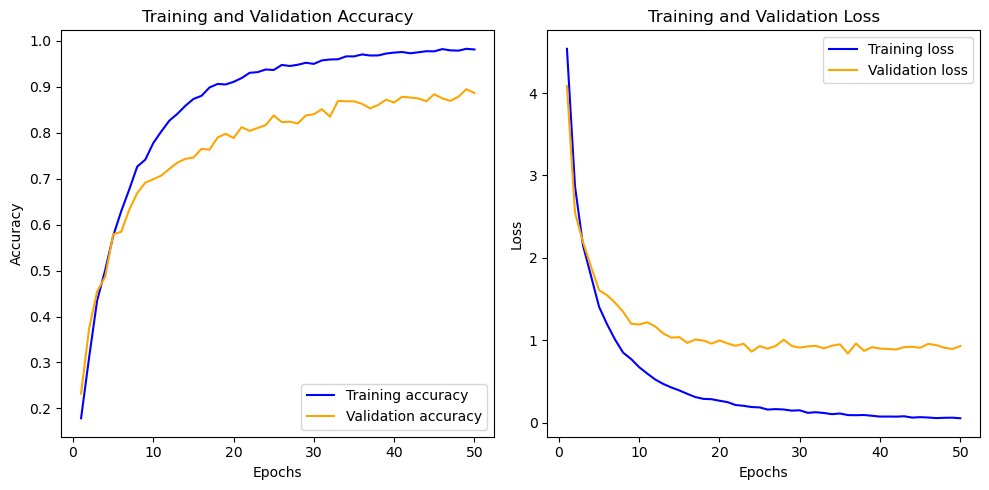

In [5]:
history_dict = history.history

# Extract acc and loss
acc_values = history_dict['accuracy'] 
val_acc_values = history_dict['val_accuracy'] 
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss']

# Get the number of epochs
epochs = range(1, len(acc_values) + 1)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the accuracy for training and validation data over epochs
ax[0].plot(epochs, acc_values, label='Training accuracy', color='blue') # Blue Line
ax[0].plot(epochs, val_acc_values, label='Validation accuracy', color='orange') # Orange Line 
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

#Plot the Loss for training and validation data over epochs
ax[1].plot(epochs, loss_values, label='Training loss', color='blue') # Blue Line
ax[1].plot(epochs, val_loss_values, label='Validation loss', color='orange') # Orange Line 
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout() 
plt.show()

In [6]:
testgen = ImageDataGenerator(
    rescale=1./255
)
test_generator = testgen.flow_from_directory(
    'data/test',
    target_size=(256, 256), 
    batch_size=64,
    class_mode='categorical',  # Change class_mode to 'categorical'
    shuffle=False
)

loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

Found 558 images belonging to 7 classes.
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 945ms/step - accuracy: 0.9170 - loss: 0.6785
Test Loss: 0.4952
Test Accuracy: 92.65%


# Model Saving

In [7]:
model.save('model_caps_roy.h5')
# Alternative format
model.save('model_caps_roy.keras')